<a href="https://colab.research.google.com/github/ElizabethEwurabena/CV_ENG_8160/blob/main/HOMEWORK_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd '/content/drive/MyDrive/CV_ENG_8160/module 3'

/content/drive/MyDrive/CV_ENG_8160/module 3


In [ ]:
## get_item works only for localization
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from pathlib import Path
from PIL import Image
import cv2
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()

In [ ]:
class CustomDataloader(Dataset):
    def __init__(self, local_dir, cls_dir, task_type=None, class_name=None, transform=None):
        self.task_type = task_type
        self.transform = transform
        self.local_dir = local_dir
        self.cls_dir = cls_dir

        # Read CSV files
        self.local_labels_df = pd.read_csv(os.path.join(local_dir, 'train.csv'))
        self.cls_labels_df = pd.read_csv(os.path.join(cls_dir, 'train.csv'))

        # Prepend zeros to filenames in the CSV files
        self.local_labels_df['img_name'] = self.local_labels_df['img_name'].apply(lambda x: str(x).zfill(8)) #zfill new function
        self.cls_labels_df['img_name'] = self.cls_labels_df['img_name'].apply(lambda x: str(x).zfill(8))

        self.local_imgs = os.path.join(local_dir, 'classd')
        self.cls_imgs = os.path.join(cls_dir, 'data')
        self.cls_img_classes = os.listdir(self.cls_imgs)
        self.class_name = class_name

    def __len__(self):
        if self.task_type == "classification":
            return len(self.cls_labels_df)
        elif self.task_type == "localization":
            return len(self.local_labels_df)

    def __getitem__(self, idx):
        if self.task_type == "classification":  #classification
            image = None
            label = None
            img_name = str(self.cls_labels_df.iloc[idx, 0]) + '.jpg'
            label = self.cls_labels_df.iloc[idx, 1]
            for class_name in self.cls_img_classes:
                class_img_folder = os.path.join(self.cls_imgs, class_name)
                for filename in os.listdir(class_img_folder):
                    if filename == img_name:
                        img_path = os.path.join(class_img_folder, filename)
                        image = io.imread(img_path)
                        break
                if image is not None:
                    break
            if image is None:
                raise FileNotFoundError(f"Image with index {idx} not found in any class folder")


        elif self.task_type == "localization": #localization
            img_name = str(self.local_labels_df.iloc[idx, 0]) + '.jpg'
            img_path = os.path.join(self.local_imgs, img_name)
            image = io.imread(img_path)
            label = self.local_labels_df.iloc[idx, 1]
            file_name = self.local_labels_df.iloc[idx, 0]
            file_rows = self.local_labels_df[self.local_labels_df.iloc[:, 0] == file_name]
            # print(file_name)
            # print(file_rows)
            for _, row in file_rows.iterrows():
              x, y, w, h = row[2:]
              x, y, w, h = int(x), int(y), int(w), int(h)
              img=cv2.rectangle(image, (x, y), (w, h), (255, 0, 0), 2)
            # plt.imshow(img)
            # plt.title(file_name)
            # plt.axis('off')
            # plt.show()

        sample = {'image': image, 'label': label}
        if self.transform:
            sample = self.transform(sample)


        return sample


class Normalization(object):
    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        image = image / 255.0  # Normalize pixel values to [0, 1]
        return {'image': image, 'label': label}

class Flip(object):
    def __init__(self, flip_type):
        assert flip_type in [0, 1]
        self.flip_type = flip_type
    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        if self.flip_type == 1:
            image = np.flip(image, axis=0)  # Vertical flip
        elif self.flip_type == 0:
            image = np.flip(image, axis=1)  # Horizontal flip
        return {'image': image, 'label': label}

from torchvision import transforms
class Rescale(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
        new_h, new_w = int(new_h), int(new_w)
        # img = transform.resize(image, (new_h, new_w))
        img = transform.resize(image, (new_h, new_w))
        return {'image': img, 'label': label}

class ToTensor(object):
    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        print(type(image))
        image = torch.from_numpy(image)
        imageT = image.transpose(1,2).transpose(0,1)
        return {'image': imageT, 'label': label}

classification

In [ ]:
local_dir = '/content/drive/MyDrive/CV_ENG_8160/module 3/localize'
cls_dir = '/content/drive/MyDrive/CV_ENG_8160/module 3/classification'

task_type = "classification"
class_name='work_van'


scale=Rescale(output_size=(640, 640))
flip=Flip(flip_type=1)
normalize=Normalization()
tensor=ToTensor()


compose_transforms = transforms.Compose([Rescale(output_size=(640, 640)),
                                         Flip(flip_type=1),
                                         Normalization(),
                                         ToTensor()
                                        ])

cls_data = CustomDataloader(local_dir, cls_dir, task_type, class_name, transform=compose_transforms)
selected_cls_image = cls_data[31]
selected_cls_image

<class 'numpy.ndarray'>


{'image': tensor([[[0.0024, 0.0024, 0.0024,  ..., 0.0030, 0.0030, 0.0030],
          [0.0024, 0.0024, 0.0024,  ..., 0.0030, 0.0030, 0.0030],
          [0.0024, 0.0023, 0.0023,  ..., 0.0030, 0.0030, 0.0030],
          ...,
          [0.0013, 0.0013, 0.0013,  ..., 0.0037, 0.0037, 0.0037],
          [0.0013, 0.0013, 0.0013,  ..., 0.0037, 0.0037, 0.0037],
          [0.0013, 0.0013, 0.0013,  ..., 0.0037, 0.0037, 0.0037]],
 
         [[0.0025, 0.0024, 0.0024,  ..., 0.0030, 0.0030, 0.0030],
          [0.0024, 0.0024, 0.0024,  ..., 0.0030, 0.0030, 0.0030],
          [0.0024, 0.0024, 0.0024,  ..., 0.0030, 0.0030, 0.0030],
          ...,
          [0.0015, 0.0014, 0.0014,  ..., 0.0036, 0.0036, 0.0036],
          [0.0015, 0.0015, 0.0015,  ..., 0.0036, 0.0036, 0.0036],
          [0.0015, 0.0015, 0.0015,  ..., 0.0036, 0.0036, 0.0036]],
 
         [[0.0026, 0.0026, 0.0026,  ..., 0.0029, 0.0029, 0.0030],
          [0.0026, 0.0025, 0.0025,  ..., 0.0030, 0.0030, 0.0030],
          [0.0025, 0.0025, 0.00

0 (274, 383, 3) single_unit_truck
1 (68, 98, 3) single_unit_truck
2 (78, 80, 3) single_unit_truck


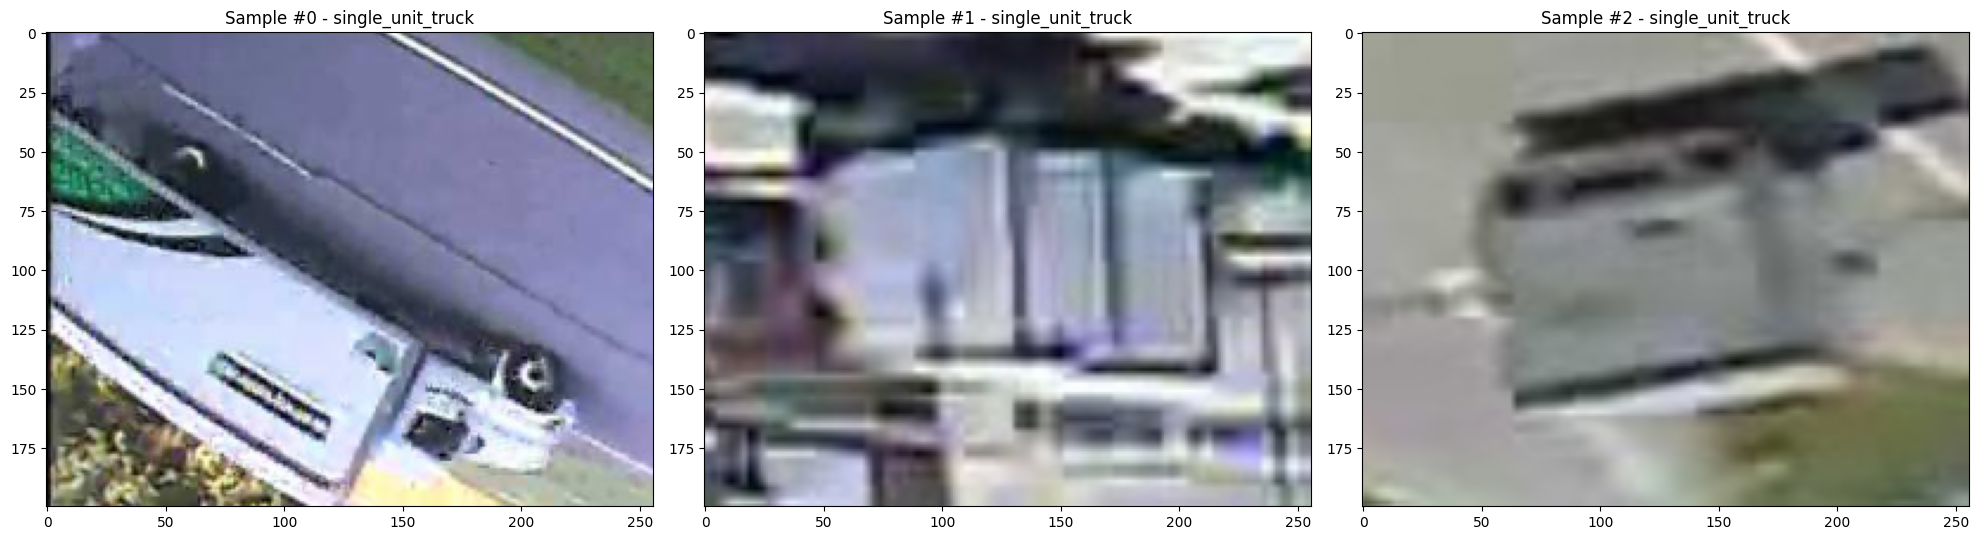

In [ ]:
local_dir = '/content/drive/MyDrive/CV_ENG_8160/module 3/localize'
cls_dir = '/content/drive/MyDrive/CV_ENG_8160/module 3/classification'

task_type = "classification"
class_name='work_van'


scale=Rescale(output_size=(200, 256))
flip=Flip(flip_type=1)
normalize=Normalization()
tensor=ToTensor()


compose_transforms = transforms.Compose([Rescale(output_size=(200, 256)),
                                         Flip(flip_type=1),
                                        #  Normalization(),
                                        #  ToTensor()
                                        ])

fig = plt.figure(figsize=(20, 20))
ncols = 3
cls_data = CustomDataloader(local_dir, cls_dir, task_type, class_name)
for i, sample in enumerate(cls_data):
    print(i, sample['image'].shape, sample['label'])
    transformed_sample = compose_transforms(sample)
    ax = plt.subplot(1, ncols, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{} - {}'.format(i, sample['label']))
    plt.imshow(transformed_sample['image'])

    if i == ncols - 1:
        plt.show()
        break


0 (274, 383, 3) single_unit_truck
1 (68, 98, 3) single_unit_truck
2 (78, 80, 3) single_unit_truck


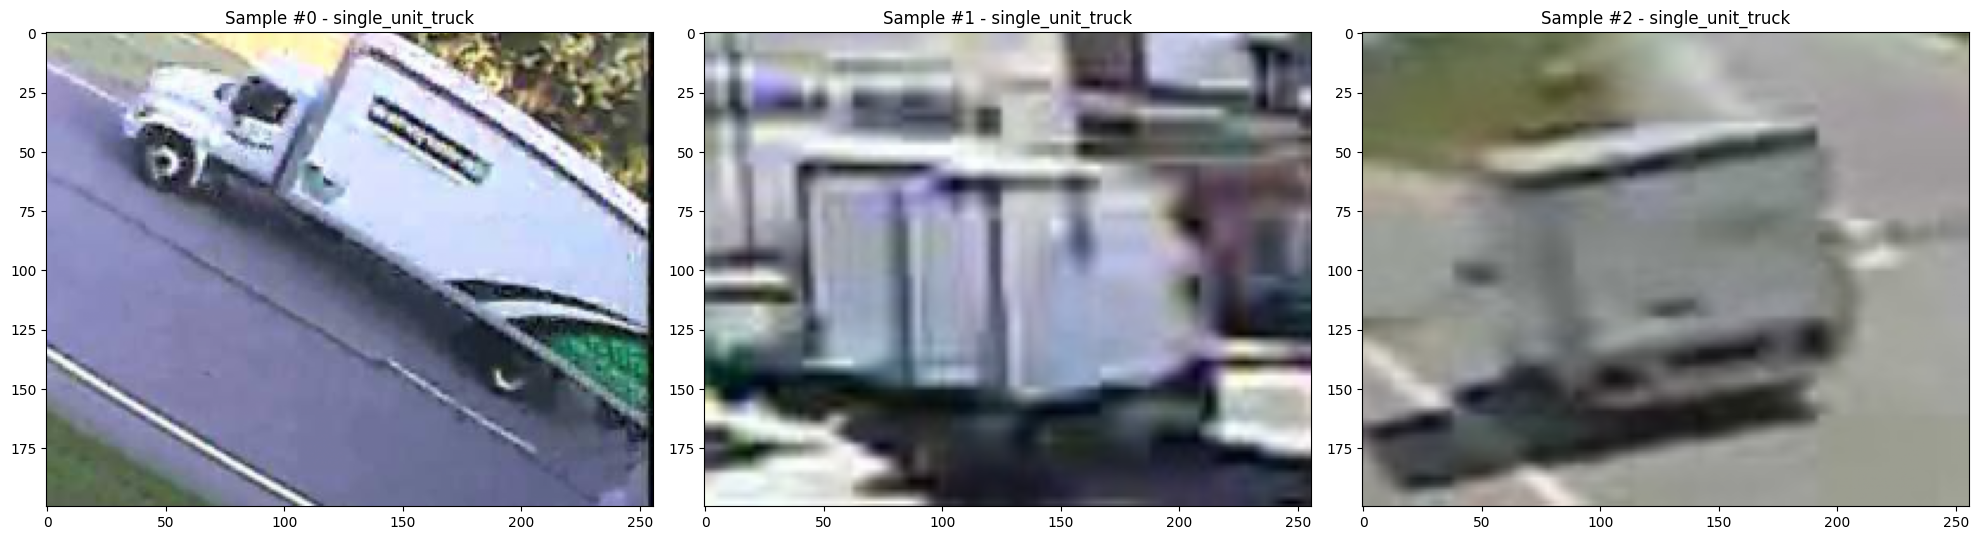

In [ ]:
local_dir = '/content/drive/MyDrive/CV_ENG_8160/module 3/localize'
cls_dir = '/content/drive/MyDrive/CV_ENG_8160/module 3/classification'

task_type = "classification"
class_name='work_van'


scale=Rescale(output_size=(200, 256))
flip=Flip(flip_type=1)
normalize=Normalization()
tensor=ToTensor()


compose_transforms = transforms.Compose([Rescale(output_size=(200, 256)),
                                         Flip(flip_type=0),
                                        #  Normalization(),
                                        #  ToTensor()
                                        ])

fig = plt.figure(figsize=(20, 20))
ncols = 3
cls_data = CustomDataloader(local_dir, cls_dir, task_type, class_name)
for i, sample in enumerate(cls_data):
    print(i, sample['image'].shape, sample['label'])
    transformed_sample = compose_transforms(sample)
    ax = plt.subplot(1, ncols, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{} - {}'.format(i, sample['label']))
    plt.imshow(transformed_sample['image'])

    if i == ncols - 1:
        plt.show()
        break

localization

In [ ]:
local_dir = '/content/drive/MyDrive/CV_ENG_8160/module 3/localize'
cls_dir = '/content/drive/MyDrive/CV_ENG_8160/module 3/classification'

task_type = "localization"
from torchvision import transforms

compose_transforms = transforms.Compose([Rescale(output_size=(640, 640)),Flip(flip_type=1), Normalization(), ToTensor()])
cls_data = CustomDataloader(local_dir, cls_dir, task_type, class_name, transform=compose_transforms)
selected_cls_image = cls_data[31]
selected_cls_image

<class 'numpy.ndarray'>


{'image': tensor([[[1.7301e-05, 9.5156e-05, 4.4214e-04,  ..., 1.0188e-04,
           1.4225e-04, 2.2587e-04],
          [1.7301e-05, 9.5156e-05, 4.4214e-04,  ..., 1.0188e-04,
           1.4225e-04, 2.2587e-04],
          [1.7301e-05, 9.5156e-05, 4.4214e-04,  ..., 1.0188e-04,
           1.4225e-04, 2.2587e-04],
          ...,
          [1.9464e-04, 3.0637e-05, 2.7754e-04,  ..., 2.3453e-04,
           2.1530e-04, 2.1530e-04],
          [1.3012e-04, 3.8567e-05, 2.3176e-04,  ..., 2.3453e-04,
           2.1530e-04, 2.1530e-04],
          [4.9861e-05, 2.4630e-05, 1.6400e-04,  ..., 2.3453e-04,
           2.1530e-04, 2.1530e-04]],
 
         [[3.2680e-05, 1.1053e-04, 4.5752e-04,  ..., 2.4990e-05,
           6.5359e-05, 1.4898e-04],
          [3.2680e-05, 1.1053e-04, 4.5752e-04,  ..., 2.4990e-05,
           6.5359e-05, 1.4898e-04],
          [3.2680e-05, 1.1053e-04, 4.5752e-04,  ..., 2.4990e-05,
           6.5359e-05, 1.4898e-04],
          ...,
          [3.0012e-04, 1.0369e-04, 3.6140e-04,  .

0 (480, 720, 3) car
1 (228, 342, 3) motorized_vehicle
2 (480, 720, 3) car


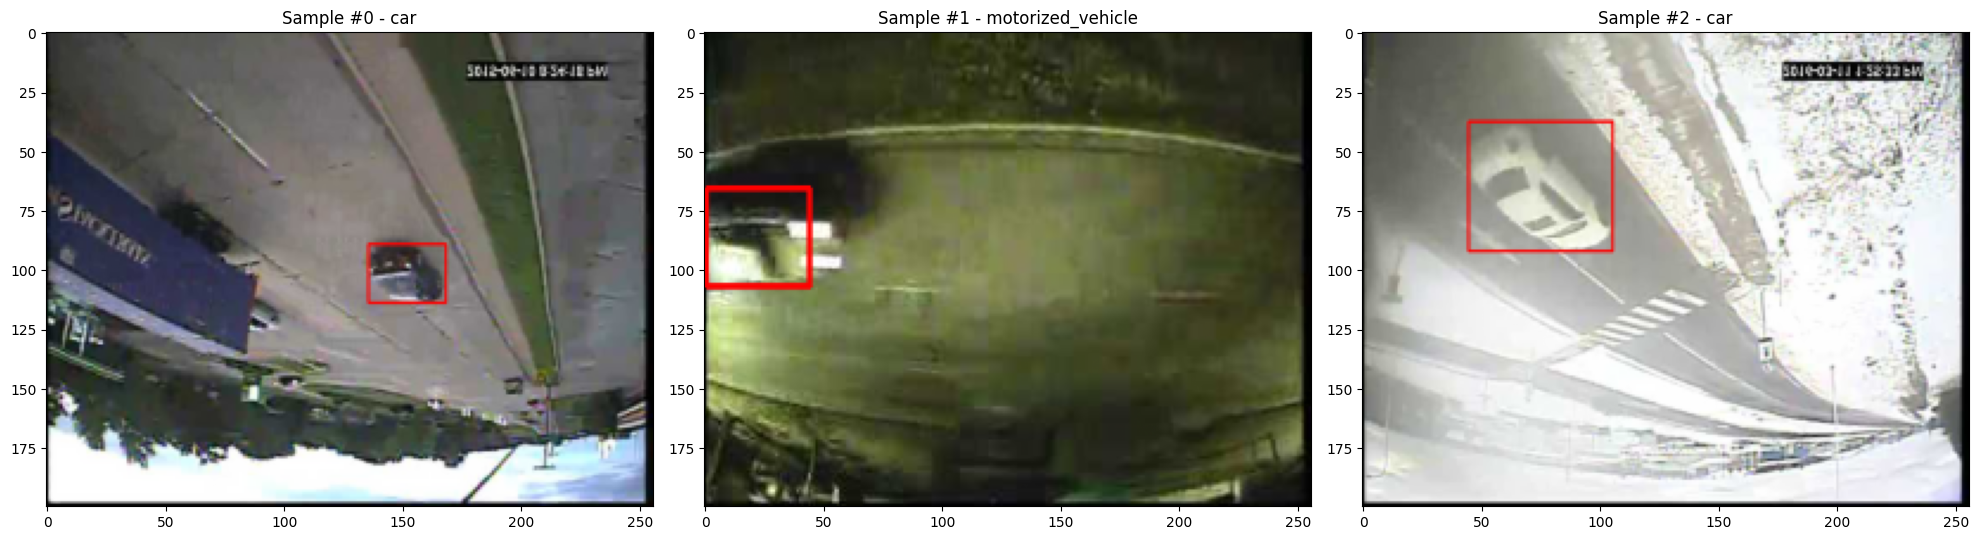

In [ ]:
local_dir = '/content/drive/MyDrive/CV_ENG_8160/module 3/localize'
cls_dir = '/content/drive/MyDrive/CV_ENG_8160/module 3/classification'

task_type = "localization"
from torchvision import transforms

scale=Rescale(output_size=(200, 256))
flip=Flip(flip_type=1)
normalize=Normalization()
tensor=ToTensor()


compose_transforms = transforms.Compose([Rescale(output_size=(200, 256)),
                                         Flip(flip_type=1),
                                        #  Normalization(),
                                        #  ToTensor()
                                        ])
fig = plt.figure(figsize=(20, 20))
ncols = 3
cls_data = CustomDataloader(local_dir, cls_dir, task_type, class_name)
for i, sample in enumerate(cls_data):
    print(i, sample['image'].shape, sample['label'])
    transformed_sample = compose_transforms(sample)
    ax = plt.subplot(1, ncols, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{} - {}'.format(i, sample['label']))
    plt.imshow(transformed_sample['image'])

    if i == ncols - 1:
        plt.show()
        break

0 (480, 720, 3) car
1 (228, 342, 3) motorized_vehicle
2 (480, 720, 3) car


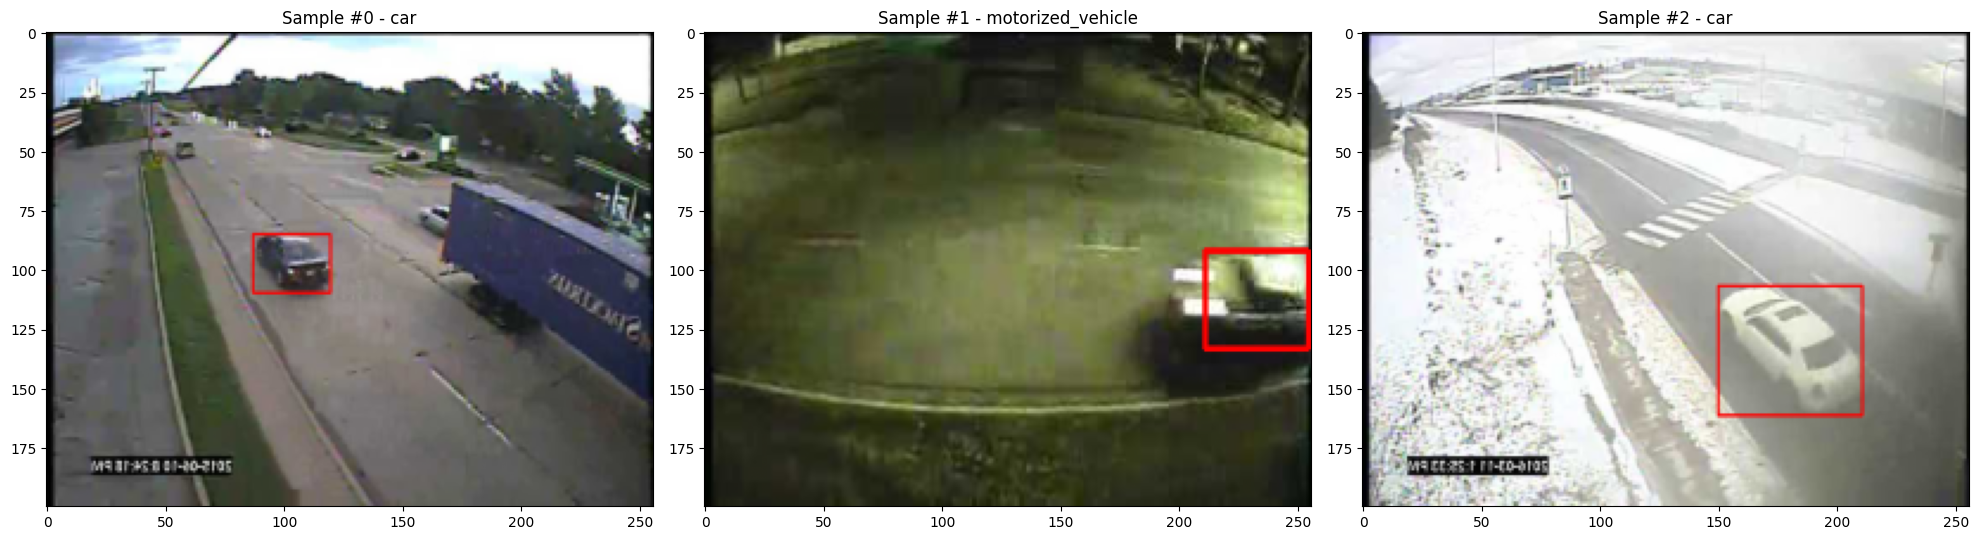

In [ ]:
local_dir = '/content/drive/MyDrive/CV_ENG_8160/module 3/localize'
cls_dir = '/content/drive/MyDrive/CV_ENG_8160/module 3/classification'

task_type = "localization"
from torchvision import transforms

scale=Rescale(output_size=(200, 256))
flip=Flip(flip_type=1)
normalize=Normalization()
tensor=ToTensor()


compose_transforms = transforms.Compose([Rescale(output_size=(200, 256)),
                                         Flip(flip_type=0),
                                        #  Normalization(),
                                        #  ToTensor()
                                        ])
fig = plt.figure(figsize=(20, 20))
ncols = 3
cls_data = CustomDataloader(local_dir, cls_dir, task_type, class_name)
for i, sample in enumerate(cls_data):
    print(i, sample['image'].shape, sample['label'])
    transformed_sample = compose_transforms(sample)
    ax = plt.subplot(1, ncols, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{} - {}'.format(i, sample['label']))
    plt.imshow(transformed_sample['image'])

    if i == ncols - 1:
        plt.show()
        break

In [ ]:
local_dir = '/content/drive/MyDrive/CV_ENG_8160/module 3/localize'
cls_dir = '/content/drive/MyDrive/CV_ENG_8160/module 3/classification'

task_type = "localization"
from torchvision import transforms

compose_transforms = transforms.Compose([Flip(flip_type=1), Normalization(), ToTensor()])
cls_data = CustomDataloader(local_dir, cls_dir, task_type, class_name, transform=compose_transforms)
selected_cls_image = cls_data[31]
image=selected_cls_image['image']
image

<class 'numpy.ndarray'>


tensor([[[0.0039, 0.0118, 0.0784,  ..., 0.0235, 0.0392, 0.0588],
         [0.0039, 0.0118, 0.0784,  ..., 0.0235, 0.0392, 0.0588],
         [0.0039, 0.0118, 0.0784,  ..., 0.0235, 0.0392, 0.0588],
         ...,
         [0.0549, 0.0000, 0.0000,  ..., 0.0549, 0.0549, 0.0549],
         [0.0510, 0.0118, 0.0157,  ..., 0.0549, 0.0549, 0.0549],
         [0.0078, 0.0039, 0.0118,  ..., 0.0549, 0.0549, 0.0549]],

        [[0.0078, 0.0157, 0.0824,  ..., 0.0039, 0.0196, 0.0392],
         [0.0078, 0.0157, 0.0824,  ..., 0.0039, 0.0196, 0.0392],
         [0.0078, 0.0157, 0.0824,  ..., 0.0039, 0.0196, 0.0392],
         ...,
         [0.0824, 0.0039, 0.0039,  ..., 0.0549, 0.0549, 0.0549],
         [0.0784, 0.0392, 0.0431,  ..., 0.0549, 0.0549, 0.0549],
         [0.0353, 0.0314, 0.0392,  ..., 0.0549, 0.0549, 0.0549]],

        [[0.0000, 0.0000, 0.0510,  ..., 0.0196, 0.0431, 0.0627],
         [0.0000, 0.0000, 0.0510,  ..., 0.0196, 0.0431, 0.0627],
         [0.0000, 0.0000, 0.0510,  ..., 0.0196, 0.0431, 0.

In [ ]:
##example use of zfill

txt = "50"

x = txt.zfill(10) #prepends a number of zeros to a string to get the specified string length

print(x)



0000000050


In [ ]:
##example use of zfill

img = "1250"

img = txt.zfill(5)

print(img)

00050


In [ ]:
#example use of cv2.rectangle

# This uses the open cv library to draw a rectangle of a specific color and thickness
# as used in the code above the choosen color (255, 0, 0) is red because 255 is in the red part of the RGB
# the chosen thickness is 2 pixels and the (x,y) from the bounding box coordinates are the starting point and the (w,h) is the endpoint.

image = cv2.rectangle(image, start_point, end_point, color, thickness)

img=cv2.rectangle(image, (x, y), (w, h), (255, 0, 0), 2)

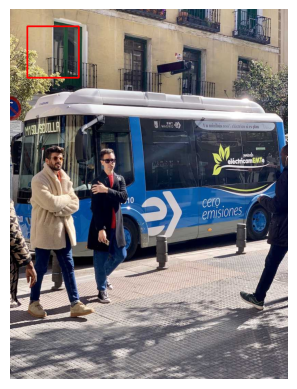

In [ ]:
import cv2

img = cv2.imread("bus.jpg")
img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)#cv2 changes channel to BGR so have to change it back to RGB
start_point = (50, 50)
end_point = (200, 200)
color = (255, 0, 0)
thickness = 3
image = cv2.rectangle(img, start_point, end_point, color, thickness)
plt.imshow(image)
plt.axis('off')
plt.show()

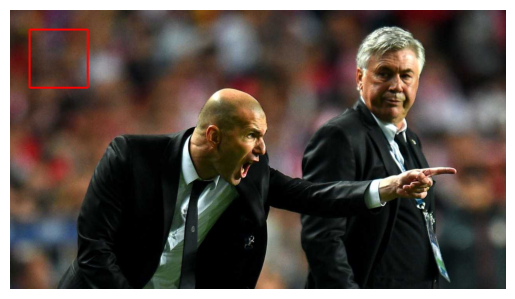

In [ ]:
import cv2

img = cv2.imread("zidane.jpg")
img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)#cv2 changes channel to BGR so have to change it back to RGB
start_point = (50, 50)
end_point = (200, 200)
color = (255, 0, 0)
thickness = 3
image = cv2.rectangle(img, start_point, end_point, color, thickness)
plt.imshow(image)
plt.axis('off')
plt.show()